-5.0
Upper OuterCoil: I= 0.000, V = 0.038497+0.923094j 
Lower OuterCoil: I= 0.000, V = 0.057753+1.543141j 
InnerCoil: I= 0.020, V = 0.41045167+3.78385170j 
-4.5
Upper OuterCoil: I= 0.000, V = 0.039503+0.952401j 
Lower OuterCoil: I= 0.000, V = 0.056946+1.514830j 
InnerCoil: I= 0.020, V = 0.41046173+3.78269341j 
-4.0
Upper OuterCoil: I= 0.000, V = 0.040521+0.982261j 
Lower OuterCoil: I= 0.000, V = 0.056111+1.485684j 
InnerCoil: I= 0.020, V = 0.41047494+3.77948336j 
-3.5
Upper OuterCoil: I= 0.000, V = 0.041535+1.012638j 
Lower OuterCoil: I= 0.000, V = 0.055249+1.455900j 
InnerCoil: I= 0.020, V = 0.41047730+3.77966558j 
-3.0
Upper OuterCoil: I= 0.000, V = 0.042549+1.043512j 
Lower OuterCoil: I= 0.000, V = 0.054356+1.425506j 
InnerCoil: I= 0.020, V = 0.41046703+3.78185205j 
-2.5
Upper OuterCoil: I= 0.000, V = 0.043569+1.074745j 
Lower OuterCoil: I= 0.000, V = 0.053443+1.394568j 
InnerCoil: I= 0.020, V = 0.41046885+3.78243695j 
-2.0
Upper OuterCoil: I= 0.000, V = 0.044582+1.106393j 
Lower Ou

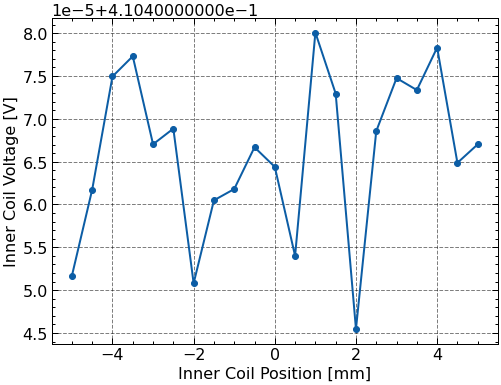

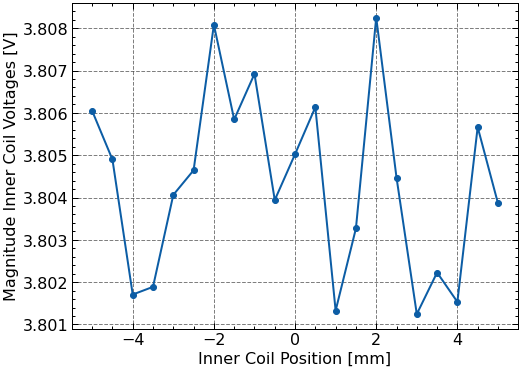

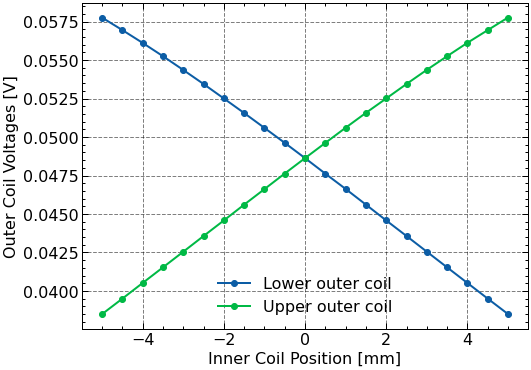

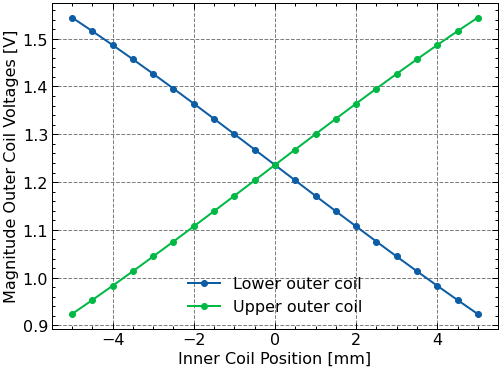

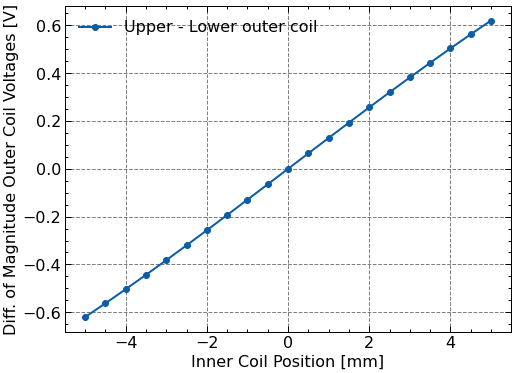

[1.46274425 1.46270879 1.46261425 1.4626188  1.46268354 1.46269966
 1.46280237 1.46273608 1.4627664  1.46268015 1.46271167 1.46274609
 1.46260203 1.46265937 1.46280863 1.46269483 1.4626011  1.46262952
 1.46260836 1.46272977 1.46267792]
[1.53338798 1.53322197 1.53304615 1.53286624 1.53268411 1.53249301
 1.5323007  1.5320912  1.53188156 1.53165754 1.53143712 1.53121923
 1.53097468 1.5307481  1.53052506 1.53027985 1.53003985 1.52980442
 1.52956852 1.52934175 1.52911025]
[1.5291159  1.52934255 1.5295668  1.52980307 1.53004422 1.53027922
 1.53052299 1.53074986 1.53098678 1.53120983 1.53143733 1.53165971
 1.53186956 1.53208215 1.53230041 1.53249108 1.53267822 1.53286601
 1.53304219 1.53322328 1.53338267]
Phase offset: -0.07064373013843017 -0.07070475503274665


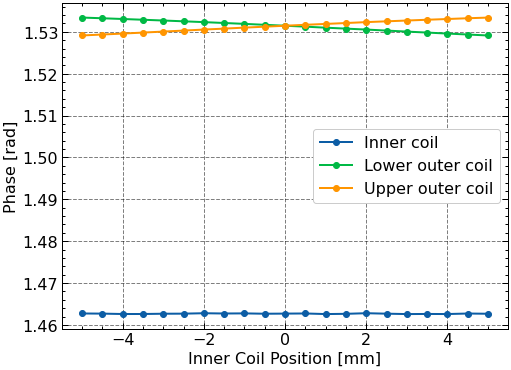

Fitted slope of the function: 12.583912015656551
[1.25839120e+01 8.06385945e-04]
Fitted slope of the function: 12.911389037267847
[1.29113890e+01 1.08774286e-03]


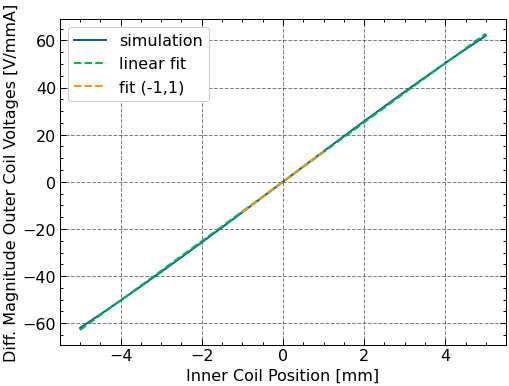

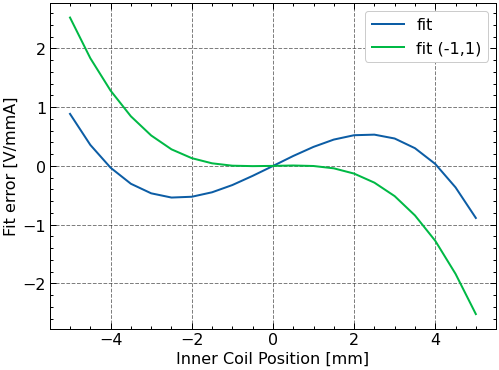

[-6.29187537e+01 -5.66267977e+01 -5.03348417e+01 -4.40428857e+01
 -3.77509297e+01 -3.14589737e+01 -2.51670176e+01 -1.88750616e+01
 -1.25831056e+01 -6.29114962e+00  8.06385945e-04  6.29276239e+00
  1.25847184e+01  1.88766744e+01  2.51686304e+01  3.14605864e+01
  3.77525424e+01  4.40444984e+01  5.03364544e+01  5.66284105e+01
  6.29203665e+01]
[-6.20324694e+01 -5.62680645e+01 -5.03646855e+01 -4.43458479e+01
 -3.82163147e+01 -3.19963294e+01 -2.56908975e+01 -1.93229128e+01
 -1.29077088e+01 -6.45941425e+00  1.70666469e-04  6.46266881e+00
  1.29097223e+01  1.93259743e+01  2.56919514e+01  3.19936787e+01
  3.82198736e+01  4.43469669e+01  5.03711020e+01  5.62640246e+01
  6.20354455e+01]


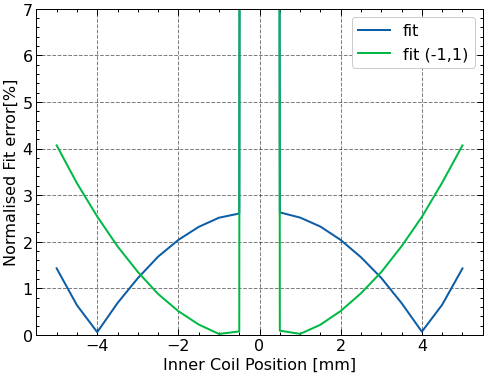

[1.42874264e+00 6.37543167e-01 5.92555418e-02 6.83180496e-01
 1.21776532e+00 1.67942943e+00 2.03916521e+00 2.31772076e+00
 2.51480074e+00 2.60495186e+00 3.72492312e+02 2.62904417e+00
 2.51751251e+00 2.32484999e+00 2.03690643e+00 1.66624264e+00
 1.22274398e+00 6.82049897e-01 6.87844976e-02 6.47635613e-01
 1.42647642e+00]


In [4]:
import design
import femm
import numpy as np
import cmath
import scipy.optimize as opt
import matplotlib.pyplot as plt
import shutil
# The package must be initialized with the openfemm command.
femm.openfemm()
# We need to create a new Magnetostatics document to work on.
femm.newdocument(0)

outputfile = 'LVDT_10kHz_20mA_31AWG_10mm_6_7_7.out'
NSteps = 20
StepSize = 0.5
InnCoil_Offset = -5

sensor = design.Sensortype(0.02, 10000, 0)
femm.mi_probdef(sensor.para()[1], 'millimeters', 'axi', 1.0e-10)
wire = design.Wiretype("31 AWG", "31 AWG")
geo = design.Geometry(inn_ht = 23, inn_rad = 9, inn_layers = 6, inn_dist = 0, out_ht = 13.5, out_rad = 21, out_layers = 7, out_dist = 28.5, mag_len = 40, mag_dia = 10, ver_shi = 0)
data_file = "outrad21_fit1_lar.txt"

class Position():
    def __init__(self):
        pass

    def inncoil(self):
        InnCoil_OutRadius = geo.inncoil()[1] + ((wire.prop31()[0] + wire.prop31()[1] * 2) * geo.inncoil()[2])
        InnCoil_Lowend = (geo.inncoil()[3] - geo.inncoil()[0]) / 2
        InnCoil_Uppend = InnCoil_Lowend + geo.inncoil()[0]
        InnCoil_NrWind_p_Layer = (geo.inncoil()[0]) / (wire.prop31()[0] + wire.prop31()[1] * 2)
        InnCoil_NrWindings = InnCoil_NrWind_p_Layer * geo.inncoil()[2]
        InnCoil_Circuit = "InnCoil_Circuit"
        return [InnCoil_OutRadius, InnCoil_Lowend, InnCoil_Uppend, InnCoil_NrWind_p_Layer, InnCoil_NrWindings,
                InnCoil_Circuit]

    def upp_outcoil(self):
        UppOutCoil_OutRadius = geo.outcoil()[1] + ((wire.prop31()[0] + wire.prop31()[1] * 2) * geo.outcoil()[2])
        UppOutCoil_LowEnd = (geo.outcoil()[3] - geo.outcoil()[0]) / 2
        UppOutCoil_UppEnd = UppOutCoil_LowEnd + geo.outcoil()[0]
        UppOutCoil_NrWind_p_Layer = (geo.outcoil()[0]) / (wire.prop31()[0] + wire.prop31()[1] * 2)
        UppOutCoil_NrWindings = UppOutCoil_NrWind_p_Layer * geo.outcoil()[2]
        UppOutCoil_Circuit = "UppOutCoil_Circuit"
        return [UppOutCoil_OutRadius, UppOutCoil_LowEnd, UppOutCoil_UppEnd, UppOutCoil_NrWind_p_Layer,
                UppOutCoil_NrWindings, UppOutCoil_Circuit]

    def low_outcoil(self):
        LowOutCoil_OutRadius = geo.outcoil()[1] + ((wire.prop31()[0] + wire.prop31()[1] * 2) * geo.outcoil()[2])
        LowOutCoil_UppEnd = -1 * ((geo.outcoil()[3] - geo.outcoil()[0]) / 2)
        LowOutCoil_LowEnd = LowOutCoil_UppEnd - geo.outcoil()[0]
        LowOutCoil_NrWind_p_Layer = (LowOutCoil_UppEnd - LowOutCoil_LowEnd) / (
                    wire.prop31()[0] + wire.prop31()[1] * 2)
        LowOutCoil_NrWindings = LowOutCoil_NrWind_p_Layer * geo.outcoil()[2]
        LowOutCoil_Circuit = "LowOutCoil_Circuit"
        return [LowOutCoil_OutRadius, LowOutCoil_UppEnd, LowOutCoil_LowEnd, LowOutCoil_NrWind_p_Layer,
                LowOutCoil_NrWindings, LowOutCoil_Circuit]

    def magnet(self):
        Magnet_UppEnd = geo.mag()[0] / 2 + geo.mag()[2]
        Magnet_LowEnd = -geo.mag()[0] / 2 + geo.mag()[2]
        Magnet_Radius = geo.mag()[1] / 2
        return [Magnet_UppEnd, Magnet_LowEnd, Magnet_Radius]
position = Position()

class Length():
    def __init__(self):
        pass

    def inncoil(self):
        InnCoil_TotalWire = 0
        for i in range(0, geo.inncoil()[2]):
            # circ = 2*np.pi*InnCoil_InRadius+i*(InnCoil_WireDiam+InnCoil_WireInsul)
            circ = 2 * np.pi * (geo.inncoil()[1] + i * (wire.prop31()[0] + wire.prop31()[1] * 2))
            InnCoil_TotalWire += circ * position.inncoil()[3]
        print("Total length of wire (mm):", InnCoil_TotalWire)
        print("\n")
        return InnCoil_TotalWire

    def upp_outcoil(self):
        UppOutCoil_TotalWire = 0
        for i in range(0, geo.outcoil()[2]):
            # circ = 2*np.pi*(UppOutCoil_InRadius+i*(UppOutCoil_WireDiam+UppOutCoil_WireInsul))
            circ = 2 * np.pi * (geo.outcoil()[1] + i * (wire.prop31()[0] + wire.prop31()[1] * 2))
            UppOutCoil_TotalWire += circ * position.upp_outcoil()[3]
        print("Total length of wire (mm):", UppOutCoil_TotalWire)
        print("\n")
        return UppOutCoil_TotalWire

    def low_outcoil(self):
        LowOutCoil_TotalWire = 0
        for i in range(0, geo.outcoil()[2]):
            # circ = 2*np.pi*LowOutCoil_InRadius+i*(LowOutCoil_WireDiam+LowOutCoil_WireInsul)
            circ = 2 * np.pi * (geo.outcoil()[1] + i * (wire.prop31()[0] + wire.prop31()[1] * 2))
            LowOutCoil_TotalWire += circ * position.low_outcoil()[3]
        print("Total length of wire (mm):", LowOutCoil_TotalWire)
        print("\n")
        return LowOutCoil_TotalWire
length = Length()

class Modelling():
    def __init__(self):
        pass
    # InnerCoil Structure
    femm.mi_drawrectangle(geo.inncoil()[1], position.inncoil()[2], position.inncoil()[0], position.inncoil()[1])
    femm.mi_addcircprop(position.inncoil()[5], sensor.para()[0], 1)
    
    if wire.inncoil_material == "31 AWG":
        femm.mi_addmaterial('31 AWG', 1, 1, 0, 0, 58, 0, 0, 1, 3, 0, 0, 1, 0.2261)
    if wire.inncoil_material == "32 AWG":
        femm.mi_getmaterial(wire.inncoil_material)
    
    femm.mi_clearselected()
    femm.mi_selectrectangle(geo.inncoil()[1], position.inncoil()[2], position.inncoil()[0], position.inncoil()[1], 4)
    femm.mi_setgroup(1)
    femm.mi_clearselected()
    femm.mi_addblocklabel(geo.inncoil()[1] + wire.prop31()[1], position.inncoil()[1] + (geo.inncoil()[0] / 2))
    femm.mi_selectlabel(geo.inncoil()[1] + wire.prop31()[1], position.inncoil()[1] + (geo.inncoil()[0] / 2))
    femm.mi_setblockprop(wire.prop31()[2], 1, 0, position.inncoil()[5], 0, 1, position.inncoil()[4])
    femm.mi_clearselected()
    
    # UpperOutCoil Structure
    femm.mi_drawrectangle(geo.outcoil()[1], position.upp_outcoil()[2], position.upp_outcoil()[0],
                          position.upp_outcoil()[1])
    femm.mi_addcircprop(position.upp_outcoil()[5], sensor.para()[2], 1)
    
    if wire.outcoil_material == "31 AWG":
        femm.mi_addmaterial('31 AWG', 1, 1, 0, 0, 58, 0, 0, 1, 3, 0, 0, 1, 0.2261)
    if wire.outcoil_material == "32 AWG":
        femm.mi_getmaterial(wire.inncoil_material)
    
    femm.mi_clearselected()
    femm.mi_selectrectangle(geo.outcoil()[1], position.upp_outcoil()[2], position.upp_outcoil()[0],
                            position.upp_outcoil()[1], 4)
    femm.mi_setgroup(3)
    femm.mi_clearselected()
    femm.mi_addblocklabel(geo.outcoil()[1] + wire.prop31()[1], position.upp_outcoil()[2] - (geo.outcoil()[0] * 0.5))
    femm.mi_selectlabel(geo.outcoil()[1] + wire.prop31()[1], position.upp_outcoil()[2] - (geo.outcoil()[0] * 0.5))
    femm.mi_setblockprop(wire.prop31()[2], 0, 0.1, position.upp_outcoil()[5], 0, 3, position.upp_outcoil()[4])
    femm.mi_clearselected()
    
    # LowerOutCoil Structure
    femm.mi_drawrectangle(geo.outcoil()[1], position.low_outcoil()[1], position.low_outcoil()[0],
                          position.low_outcoil()[2])
    femm.mi_addcircprop(position.low_outcoil()[5], -sensor.para()[2], 1)
    
    if wire.outcoil_material == "31 AWG":
        femm.mi_addmaterial('31 AWG', 1, 1, 0, 0, 58, 0, 0, 1, 3, 0, 0, 1, 0.2261)
    if wire.outcoil_material == "32 AWG":
        femm.mi_getmaterial(wire.inncoil_material)
    
    femm.mi_clearselected()
    femm.mi_selectrectangle(geo.outcoil()[1], position.low_outcoil()[1], position.low_outcoil()[0],
                            position.low_outcoil()[2], 4)
    femm.mi_setgroup(4)
    femm.mi_clearselected()
    femm.mi_addblocklabel(geo.outcoil()[1] + wire.prop31()[0], position.low_outcoil()[2] + (geo.outcoil()[0] * 0.5))
    femm.mi_selectlabel(geo.outcoil()[1] + wire.prop31()[0], position.low_outcoil()[2] + (geo.outcoil()[0] * 0.5))
    femm.mi_setblockprop(wire.prop31()[2], 0, 0.1, position.low_outcoil()[5], 0, 4, position.low_outcoil()[4])
    femm.mi_clearselected()
    
    # Magnet Structure
    femm.mi_drawrectangle(0, position.magnet()[0], position.magnet()[2], position.magnet()[1])
    femm.mi_getmaterial(wire.mag_mat())
    femm.mi_clearselected()
    femm.mi_selectrectangle(0, position.magnet()[0], position.magnet()[2], position.magnet()[1], 4)
    femm.mi_setgroup(2)
    femm.mi_clearselected()
    femm.mi_addblocklabel(position.magnet()[2] * 0.5, position.magnet()[1] + (geo.mag()[0] * 0.5))
    femm.mi_selectlabel(position.magnet()[2] * 0.5, position.magnet()[1] + (geo.mag()[0] * 0.5))
    femm.mi_setblockprop(wire.mag_mat(), 0, 0.1, "", 90, 2, 0)
    femm.mi_clearselected()
    
    # AirSurrounding Structure
    AirSpaceRadius_1 = 100
    AirSpaceRadius_2 = 300
    BC_Name = "Outside"
    BC_Group = 10
    # Airspace1
    femm.mi_drawline(0, AirSpaceRadius_1, 0, -AirSpaceRadius_1)
    femm.mi_drawarc(0, -AirSpaceRadius_1, 0, AirSpaceRadius_1, 180, 2)
    femm.mi_getmaterial("Air")
    femm.mi_clearselected()
    femm.mi_addblocklabel(AirSpaceRadius_1 / 4, AirSpaceRadius_1 / 2)
    femm.mi_selectlabel(AirSpaceRadius_1 / 4, AirSpaceRadius_1 / 2)
    femm.mi_setblockprop("Air", 0, 0.5, '', 0, 0, 0)
    femm.mi_clearselected()
    # Airspace2
    femm.mi_drawline(0, AirSpaceRadius_2, 0, -AirSpaceRadius_2)
    femm.mi_drawarc(0, -AirSpaceRadius_2, 0, AirSpaceRadius_2, 180, 2)
    femm.mi_getmaterial("Air")
    femm.mi_clearselected()
    femm.mi_addblocklabel(AirSpaceRadius_2 / 2, AirSpaceRadius_2 / 1.2)
    femm.mi_selectlabel(AirSpaceRadius_2 / 2, AirSpaceRadius_2 / 1.2)
    femm.mi_setblockprop("Air", 1, 0, '', 0, 0, 0)
    femm.mi_clearselected()
    # Boundary properties
    femm.mi_addboundprop(BC_Name, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
    femm.mi_clearselected()
    femm.mi_selectarcsegment(0, AirSpaceRadius_2)
    femm.mi_setarcsegmentprop(2, BC_Name, 0, BC_Group)
    femm.mi_clearselected()
    
    UppOutCoil_Voltages = np.zeros(NSteps + 1).astype(complex)
    LowOutCoil_Voltages = np.zeros(NSteps + 1).astype(complex)
    InnCoil_Voltages = np.zeros(NSteps + 1).astype(complex)
    InnCoil_Positions = np.zeros(NSteps + 1)
    MetaData = np.zeros(NSteps + 1)
    
    femm.mi_selectgroup(1)
    femm.mi_selectgroup(2)
    femm.mi_movetranslate(0, InnCoil_Offset)
    femm.mi_clearselected()
modelled = Modelling()

class Computation_loop():
    def __init__(self):
        pass
    for i in range(0, NSteps + 1):

        print(InnCoil_Offset + StepSize * i)
        modelled.InnCoil_Positions[i] = InnCoil_Offset + (StepSize * i)

        # Now, the finished input geometry can be displayed.
        # femm.mi_zoomnatural()
        femm.mi_zoom(-2, -50, 50, 50)
        femm.mi_refreshview()

        # We have to give the geometry a name before we can analyze it.
        femm.mi_saveas('LVDT position_ETpf_LIP.fem')

        # Now,analyze the problem and load the solution when the analysis is finished
        femm.mi_analyze()
        femm.mi_loadsolution()

        if NSteps == 0:
            # Show Density Plot:
            femm.mo_showdensityplot(1, 0, 0.0001, 1.0E-9, "bmag")
            # --legend,	(0=hide, 1=show)
            # --gscale,	(0=color, 1=greyscale)
            # --upper_B,	(upperlimit for display)
            # --lower_B,	(lowerlimit for display)
            # --type		("bmag", "breal", "bimag" FluxDensity)
            # --			("hmag", "hreal", "himag" FieldIntensity)
            # --			("jmag", "jreal", "jimag" CurrentDensity)
            femm.mo_zoom(-2, -50, 50, 50)
            femm.mo_refreshview()

        UppOutCoil_I, UppOutCoil_V, UppOutCoil_FluxLink = femm.mo_getcircuitproperties(position.upp_outcoil()[5])
        print("Upper OuterCoil: I= {:.3f}, V = {:.6f} ".format(UppOutCoil_I, UppOutCoil_V))
        modelled.UppOutCoil_Voltages[i] = UppOutCoil_V

        LowOutCoil_I, LowOutCoil_V, LowOutCoil_FluxLink = femm.mo_getcircuitproperties(position.low_outcoil()[5])
        print("Lower OuterCoil: I= {:.3f}, V = {:.6f} ".format(LowOutCoil_I, LowOutCoil_V))
        modelled.LowOutCoil_Voltages[i] = LowOutCoil_V

        InnCoil_I, InnCoil_V, InnCoil_FluxLink = femm.mo_getcircuitproperties(position.inncoil()[5])
        print("InnerCoil: I= {:.3f}, V = {:.8f} ".format(InnCoil_I, InnCoil_V))
        modelled.InnCoil_Voltages[i] = InnCoil_V

        # Translate inner coil to different distance
        femm.mi_selectgroup(1)
        femm.mi_selectgroup(2)
        femm.mi_movetranslate(0, StepSize)
        femm.mi_clearselected()
loop = Computation_loop()

print(modelled.InnCoil_Positions)
print(modelled.UppOutCoil_Voltages)
print(modelled.LowOutCoil_Voltages)
print(modelled.InnCoil_Voltages)

if NSteps > 2:
    modelled.MetaData[0] = NSteps
    modelled.MetaData[1] = StepSize
    modelled.MetaData[2] = sensor.para()[2]
    np.savetxt(outputfile,
               (modelled.InnCoil_Positions, modelled.UppOutCoil_Voltages, modelled.LowOutCoil_Voltages, modelled.InnCoil_Voltages, modelled.MetaData))

plt.style.use(['science', 'grid', 'notebook'])

class Results():
    def __init__(self):
        pass
    plt.plot(modelled.InnCoil_Positions, modelled.InnCoil_Voltages.real, 'o-')
    plt.ylabel('Inner Coil Voltage [V]')
    plt.xlabel('Inner Coil Position [mm]')
    #plt.savefig("inn_vol.png")
    #shutil.move("inn_vol.png", r"C:\Users\kumar\OneDrive\Desktop\pi\lvdt\small, large ip\small_IP\outwidth variation\outwid=13.5_0")
    plt.show()

    plt.plot(modelled.InnCoil_Positions, abs(modelled.InnCoil_Voltages), 'o-')
    plt.ylabel('Magnitude Inner Coil Voltages [V]')
    plt.xlabel('Inner Coil Position [mm]')
    #plt.savefig("inn_mag_vol.png")
    #shutil.move("inn_mag_vol.png", r"C:\Users\kumar\OneDrive\Desktop\pi\lvdt\small, large ip\small_IP\outwidth variation\outwid=13.5_0")
    plt.show()

    plt.plot(modelled.InnCoil_Positions, modelled.LowOutCoil_Voltages.real, 'o-', label="Lower outer coil")
    plt.plot(modelled.InnCoil_Positions, modelled.UppOutCoil_Voltages.real, 'o-', label="Upper outer coil")
    plt.ylabel('Outer Coil Voltages [V]')
    plt.xlabel('Inner Coil Position [mm]')
    plt.legend(frameon=False)
    #plt.savefig("out_vol.png")
    #shutil.move("out_vol.png", r"C:\Users\kumar\OneDrive\Desktop\pi\lvdt\small, large ip\small_IP\outwidth variation\outwid=13.5_0")
    plt.show()

    plt.plot(modelled.InnCoil_Positions, abs(modelled.LowOutCoil_Voltages), 'o-', label="Lower outer coil")
    plt.plot(modelled.InnCoil_Positions, abs(modelled.UppOutCoil_Voltages), 'o-', label="Upper outer coil")
    plt.ylabel('Magnitude Outer Coil Voltages [V]')
    plt.xlabel('Inner Coil Position [mm]')
    plt.legend(frameon=False)
    #plt.savefig("abs_low,out_vol.png")
    #shutil.move("abs_low,out_vol.png", r"C:\Users\kumar\OneDrive\Desktop\pi\lvdt\small, large ip\small_IP\outwidth variation\outwid=13.5_0")
    plt.show()

    plt.plot(modelled.InnCoil_Positions, abs(modelled.UppOutCoil_Voltages) - abs(modelled.LowOutCoil_Voltages), 'o-',
             label="Upper - Lower outer coil", )
    plt.ylabel('Diff. of Magnitude Outer Coil Voltages [V]')
    plt.xlabel('Inner Coil Position [mm]')
    plt.legend(frameon=False)
    #plt.savefig("vol_diff.png")
    #shutil.move("vol_diff.png", r"C:\Users\kumar\OneDrive\Desktop\pi\lvdt\small, large ip\small_IP\outwidth variation\outwid=13.5_0")
    plt.show()

    InnCoil_Phases = np.angle(modelled.InnCoil_Voltages)
    LowOutCoil_Phases = np.angle(modelled.LowOutCoil_Voltages)
    UppOutCoil_Phases = np.angle(modelled.UppOutCoil_Voltages)
    print(InnCoil_Phases)
    print(LowOutCoil_Phases)
    print(UppOutCoil_Phases)
    print("Phase offset:", InnCoil_Phases[0] - LowOutCoil_Phases[0], InnCoil_Phases[NSteps] - UppOutCoil_Phases[NSteps])

    plt.plot(modelled.InnCoil_Positions, InnCoil_Phases, 'o-', label="Inner coil")
    plt.plot(modelled.InnCoil_Positions, LowOutCoil_Phases, 'o-', label="Lower outer coil")
    plt.plot(modelled.InnCoil_Positions, UppOutCoil_Phases, 'o-', label="Upper outer coil")
    plt.ylabel('Phase [rad]')
    plt.xlabel('Inner Coil Position [mm]')
    plt.legend()
    #plt.savefig("phase.png")
    #shutil.move("phase.png", r"C:\Users\kumar\OneDrive\Desktop\pi\lvdt\small, large ip\small_IP\outwidth variation\outwid=13.5_0")
    plt.show()

    Norm_OutCoil_Signals = (abs(modelled.UppOutCoil_Voltages) - abs(modelled.LowOutCoil_Voltages)) / StepSize / sensor.para()[0]

    def linfunc(x, a, b):
        return a * x + b
        # ydata: Norm_OutCoil_Signals
        # xdata: InnCoil_Position

    optimizedParameters, pcov = opt.curve_fit(linfunc, modelled.InnCoil_Positions, Norm_OutCoil_Signals);
    print("Fitted slope of the function:", optimizedParameters[0])
    fitted_Norm_OutCoil_Signals = linfunc(modelled.InnCoil_Positions, *optimizedParameters)
    print(optimizedParameters)

    InnCoil_Positions1 = modelled.InnCoil_Positions[8:13]
    Norm_OutCoil_Signals1 = Norm_OutCoil_Signals[8:13]
    optimizedparameters1, pcov = opt.curve_fit(linfunc, InnCoil_Positions1, Norm_OutCoil_Signals1)
    print("Fitted slope of the function:", optimizedparameters1[0])
    fitted_Norm_OutCoil_Signals1 = linfunc(InnCoil_Positions1, *optimizedparameters1)
    print(optimizedparameters1)

    plt.plot(modelled.InnCoil_Positions, Norm_OutCoil_Signals, label="simulation")
    plt.plot(modelled.InnCoil_Positions, fitted_Norm_OutCoil_Signals, '--', label="linear fit")
    plt.plot(InnCoil_Positions1, fitted_Norm_OutCoil_Signals1, '--', label="fit (-1,1)")
    plt.ylabel('Diff. Magnitude Outer Coil Voltages [V/mmA]')
    plt.xlabel('Inner Coil Position [mm]')
    #plt.ylim(0,20)
    plt.legend()
    #plt.savefig("linfit_pen3_lar.png")
    #shutil.move("linfit_pen3_lar.png", r"C:\Users\kumar\OneDrive\Desktop\pi\lvdt\small, large ip\small_IP\res\subfit")
    plt.show()

    plt.plot(modelled.InnCoil_Positions, Norm_OutCoil_Signals - fitted_Norm_OutCoil_Signals, label = "fit")
    plt.plot(modelled.InnCoil_Positions, Norm_OutCoil_Signals - optimizedparameters1[0]*(np.array(modelled.InnCoil_Positions))+optimizedparameters1[1], label="fit (-1,1)")
    plt.ylabel('Fit error [V/mmA]')
    plt.xlabel('Inner Coil Position [mm]')
    plt.legend()
    #plt.savefig("fiterr_pen3_lar.png")
    #shutil.move("fiterr_pen3_lar.png", r"C:\Users\kumar\OneDrive\Desktop\pi\lvdt\small, large ip\small_IP\res\subfit")
    plt.show()

    print(fitted_Norm_OutCoil_Signals)
    print(Norm_OutCoil_Signals)
    fiterror = np.array(Norm_OutCoil_Signals) - np.array(fitted_Norm_OutCoil_Signals)

    plt.plot(modelled.InnCoil_Positions, (abs(np.array(Norm_OutCoil_Signals) - np.array(fitted_Norm_OutCoil_Signals)) / abs(np.array(Norm_OutCoil_Signals)))*100, label = "fit")
    plt.plot(modelled.InnCoil_Positions, (abs(np.array(Norm_OutCoil_Signals) - np.array(optimizedparameters1[0]*(np.array(modelled.InnCoil_Positions))+optimizedparameters1[1])) / abs(np.array(Norm_OutCoil_Signals)))*100, label = "fit (-1,1)")
    plt.ylabel('Normalised Fit error[%]')
    plt.xlabel('Inner Coil Position [mm]')
    plt.ylim(0.0, 7)
    plt.legend()
    #plt.savefig("normfiterr_pen3_lar.png")
    #shutil.move("normfiterr_pen3_lar.png", r"C:\Users\kumar\OneDrive\Desktop\pi\lvdt\small, large ip\small_IP\res\subfit")
    plt.show()
results = Results()

class Save_data():
    def __init__(self):
        pass
    #print(fitted_Norm_OutCoil_Signals1)
    fit1 = results.optimizedparameters1[0]*(np.array(modelled.InnCoil_Positions))+results.optimizedparameters1[1]
    fit_err1 = results.Norm_OutCoil_Signals - results.optimizedparameters1[0]*(np.array(modelled.InnCoil_Positions))+results.optimizedparameters1[1]
    norm_fit_err1 = (abs(np.array(results.Norm_OutCoil_Signals) - np.array(results.optimizedparameters1[0]*(np.array(modelled.InnCoil_Positions))+results.optimizedparameters1[1])) / abs(np.array(results.Norm_OutCoil_Signals)))*100
    norm_fit_error = (abs(np.array(results.Norm_OutCoil_Signals) - np.array(results.fitted_Norm_OutCoil_Signals)) / abs(np.array(results.Norm_OutCoil_Signals)))*100
    print(norm_fit_error)
    data = np.column_stack((modelled.InnCoil_Positions, modelled.UppOutCoil_Voltages, modelled.LowOutCoil_Voltages, modelled.InnCoil_Voltages,  results.Norm_OutCoil_Signals, fit1, norm_fit_err1))
    np.savetxt(data_file, data)
saved_data = Save_data()



In [ ]:
lis = np.zeros(3)
lis1 = np.array(lis+3)
print(lis1)